# 01 - Exploratory Analysis: "Wait, Are MYR and SGD Even Related?"

Welcome to the repo of **Mandilah-Singapura**, where we ask the real questions:
- Do Malaysia and Singapore secretly share one brain?
- Or is MYR just SGD's chaotic younger sibling who refuses to grow up?

### In This Notebook, We:
- Pull USD/MYR and USD/SGD from FRED (because free data = love)
- Compute the **true** MYR/SGD cross rate (yes, it exists, and it's dramatic)
- Plot everything like we're making a Netflix documentary
- Calculate correlations and pretend we understand macroeconomics
- Cry a little when we see the 2015–2016 oil crash

**Spoiler**: They move together... sometimes. Like cousins at a wedding — same vibe, different energy.

# 02 - Regime Analysis: "The MYR/SGD Identity Crisis (2000–2025)"

This notebook is basically a therapy session for the MYR/SGD spread.

We discovered it has **four distinct personalities**:
1. **1998–2005**: "I have a peg and I'm not afraid to use it" (MYR fixed → spread collapses)
2. **2005–2014**: The chill drifting era
3. **2015–2020**: Oil crash + 1MDB drama = emotional damage
4. **2021–now**: Suddenly calm, mature, mean-reverting. Who hurt you? Who fixed you?

### What You'll Do Here:
- Split the data into regimes (like a currency divorce lawyer)
- Run ADF tests and watch p-values go from 0.99 → 0.001 like magic
- Realize mean-reversion only works when Malaysia and Singapore are getting along
- Feel personally betrayed by 2016

**Conclusion**: Never trade MYR/SGD mean-reversion on the full sample. You will lose money and your will to live.
But from 2021 onward? *chef's kiss*

In [1]:
# Import necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
import warnings
warnings.filterwarnings('ignore')

# Set up plotting style
plt.style.use('seaborn-v0_8')
sns.set_palette("husl")

print("Libraries imported successfully!")
print("Ready to dive into the MYR/SGD relationship drama! 🎭")

Libraries imported successfully!
Ready to dive into the MYR/SGD relationship drama! 🎭


In [2]:
# Load the currency data
print("Loading USD/MYR and USD/SGD data...")

# Load USD/MYR data
usd_myr = pd.read_csv('data/usd_myr.csv')
print(f"USD/MYR data shape: {usd_myr.shape}")

# Load USD/SGD data  
usd_sgd = pd.read_csv('data/usd_sgd.csv')
print(f"USD/SGD data shape: {usd_sgd.shape}")

# Display first few rows of each dataset
print("\n=== USD/MYR Data Sample ===")
print(usd_myr.head())

print("\n=== USD/SGD Data Sample ===")
print(usd_sgd.head())

# Check data types and info
print("\n=== USD/MYR Info ===")
print(usd_myr.info())

print("\n=== USD/SGD Info ===")
print(usd_sgd.info())

Loading USD/MYR and USD/SGD data...
USD/MYR data shape: (6740, 2)
USD/SGD data shape: (6740, 2)

=== USD/MYR Data Sample ===
  observation_date  DEXMAUS
0       2000-01-03      3.8
1       2000-01-04      3.8
2       2000-01-05      3.8
3       2000-01-06      3.8
4       2000-01-07      3.8

=== USD/SGD Data Sample ===
  observation_date  DEXSIUS
0       2000-01-03   1.6563
1       2000-01-04   1.6535
2       2000-01-05   1.6560
3       2000-01-06   1.6655
4       2000-01-07   1.6625

=== USD/MYR Info ===
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6740 entries, 0 to 6739
Data columns (total 2 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   observation_date  6740 non-null   object 
 1   DEXMAUS           6478 non-null   float64
dtypes: float64(1), object(1)
memory usage: 105.4+ KB
None

=== USD/SGD Info ===
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6740 entries, 0 to 6739
Data columns (total 2 columns):
 #   Co

In [3]:
# Data cleaning and preparation
print("🧹 Cleaning the data (because messy data = messy relationships)")

# Convert observation_date to datetime
usd_myr['observation_date'] = pd.to_datetime(usd_myr['observation_date'])
usd_sgd['observation_date'] = pd.to_datetime(usd_sgd['observation_date'])

# Rename columns for clarity
usd_myr = usd_myr.rename(columns={'DEXMAUS': 'USD_MYR'})
usd_sgd = usd_sgd.rename(columns={'DEXSIUS': 'USD_SGD'})

# Check for missing values
print(f"Missing values in USD/MYR: {usd_myr['USD_MYR'].isnull().sum()}")
print(f"Missing values in USD/SGD: {usd_sgd['USD_SGD'].isnull().sum()}")

# Merge the datasets on date
df = pd.merge(usd_myr, usd_sgd, on='observation_date', how='inner')
print(f"\nMerged dataset shape: {df.shape}")

# Drop rows with missing values
df_clean = df.dropna()
print(f"Clean dataset shape (after dropping NaN): {df_clean.shape}")

# Compute the MYR/SGD cross rate
# MYR/SGD = (USD/MYR) / (USD/SGD)
df_clean['MYR_SGD'] = df_clean['USD_MYR'] / df_clean['USD_SGD']

# Set date as index for time series analysis
df_clean = df_clean.set_index('observation_date')

print(f"\n🎉 Data preparation complete!")
print(f"Date range: {df_clean.index.min()} to {df_clean.index.max()}")
print(f"Total trading days: {len(df_clean)}")

# Display the final dataset
print("\n=== Final Dataset Sample ===")
print(df_clean.head(10))

🧹 Cleaning the data (because messy data = messy relationships)
Missing values in USD/MYR: 262
Missing values in USD/SGD: 262

Merged dataset shape: (6740, 3)
Clean dataset shape (after dropping NaN): (6478, 3)

🎉 Data preparation complete!
Date range: 2000-01-03 00:00:00 to 2025-10-31 00:00:00
Total trading days: 6478

=== Final Dataset Sample ===
                  USD_MYR  USD_SGD   MYR_SGD
observation_date                            
2000-01-03            3.8   1.6563  2.294270
2000-01-04            3.8   1.6535  2.298155
2000-01-05            3.8   1.6560  2.294686
2000-01-06            3.8   1.6655  2.281597
2000-01-07            3.8   1.6625  2.285714
2000-01-10            3.8   1.6618  2.286677
2000-01-11            3.8   1.6690  2.276812
2000-01-12            3.8   1.6690  2.276812
2000-01-13            3.8   1.6700  2.275449
2000-01-14            3.8   1.6752  2.268386


In [4]:
# Basic Statistical Analysis
print("📊 Let's get to know our currency couples better...")

# Basic statistics
print("=== BASIC STATISTICS ===")
print(df_clean.describe())

print("\n=== MYR/SGD CROSS RATE INSIGHTS ===")
print(f"Mean MYR/SGD rate: {df_clean['MYR_SGD'].mean():.4f}")
print(f"Median MYR/SGD rate: {df_clean['MYR_SGD'].median():.4f}")
print(f"Standard deviation: {df_clean['MYR_SGD'].std():.4f}")
print(f"Min MYR/SGD rate: {df_clean['MYR_SGD'].min():.4f} on {df_clean['MYR_SGD'].idxmin()}")
print(f"Max MYR/SGD rate: {df_clean['MYR_SGD'].max():.4f} on {df_clean['MYR_SGD'].idxmax()}")

# Calculate daily returns
df_clean['MYR_SGD_returns'] = df_clean['MYR_SGD'].pct_change()
df_clean['USD_MYR_returns'] = df_clean['USD_MYR'].pct_change()
df_clean['USD_SGD_returns'] = df_clean['USD_SGD'].pct_change()

print(f"\n=== VOLATILITY ANALYSIS ===")
print(f"MYR/SGD daily volatility: {df_clean['MYR_SGD_returns'].std():.4f}")
print(f"USD/MYR daily volatility: {df_clean['USD_MYR_returns'].std():.4f}")
print(f"USD/SGD daily volatility: {df_clean['USD_SGD_returns'].std():.4f}")

# Annualized volatility (assuming 252 trading days)
print(f"\n=== ANNUALIZED VOLATILITY ===")
print(f"MYR/SGD: {df_clean['MYR_SGD_returns'].std() * np.sqrt(252):.2%}")
print(f"USD/MYR: {df_clean['USD_MYR_returns'].std() * np.sqrt(252):.2%}")
print(f"USD/SGD: {df_clean['USD_SGD_returns'].std() * np.sqrt(252):.2%}")

📊 Let's get to know our currency couples better...
=== BASIC STATISTICS ===
           USD_MYR      USD_SGD      MYR_SGD
count  6478.000000  6478.000000  6478.000000
mean      3.812108     1.450903     2.659587
std       0.458805     0.175780     0.426232
min       2.937000     1.200700     2.049622
25%       3.449250     1.335400     2.290484
50%       3.800000     1.376800     2.491599
75%       4.177650     1.586375     3.054048
max       4.797500     1.854000     3.571694

=== MYR/SGD CROSS RATE INSIGHTS ===
Mean MYR/SGD rate: 2.6596
Median MYR/SGD rate: 2.4916
Standard deviation: 0.4262
Min MYR/SGD rate: 2.0496 on 2001-12-27 00:00:00
Max MYR/SGD rate: 3.5717 on 2024-02-20 00:00:00

=== VOLATILITY ANALYSIS ===
MYR/SGD daily volatility: 0.0035
USD/MYR daily volatility: 0.0035
USD/SGD daily volatility: 0.0032

=== ANNUALIZED VOLATILITY ===
MYR/SGD: 5.55%
USD/MYR: 5.58%
USD/SGD: 5.10%


🎬 Creating plots worthy of a Netflix documentary...


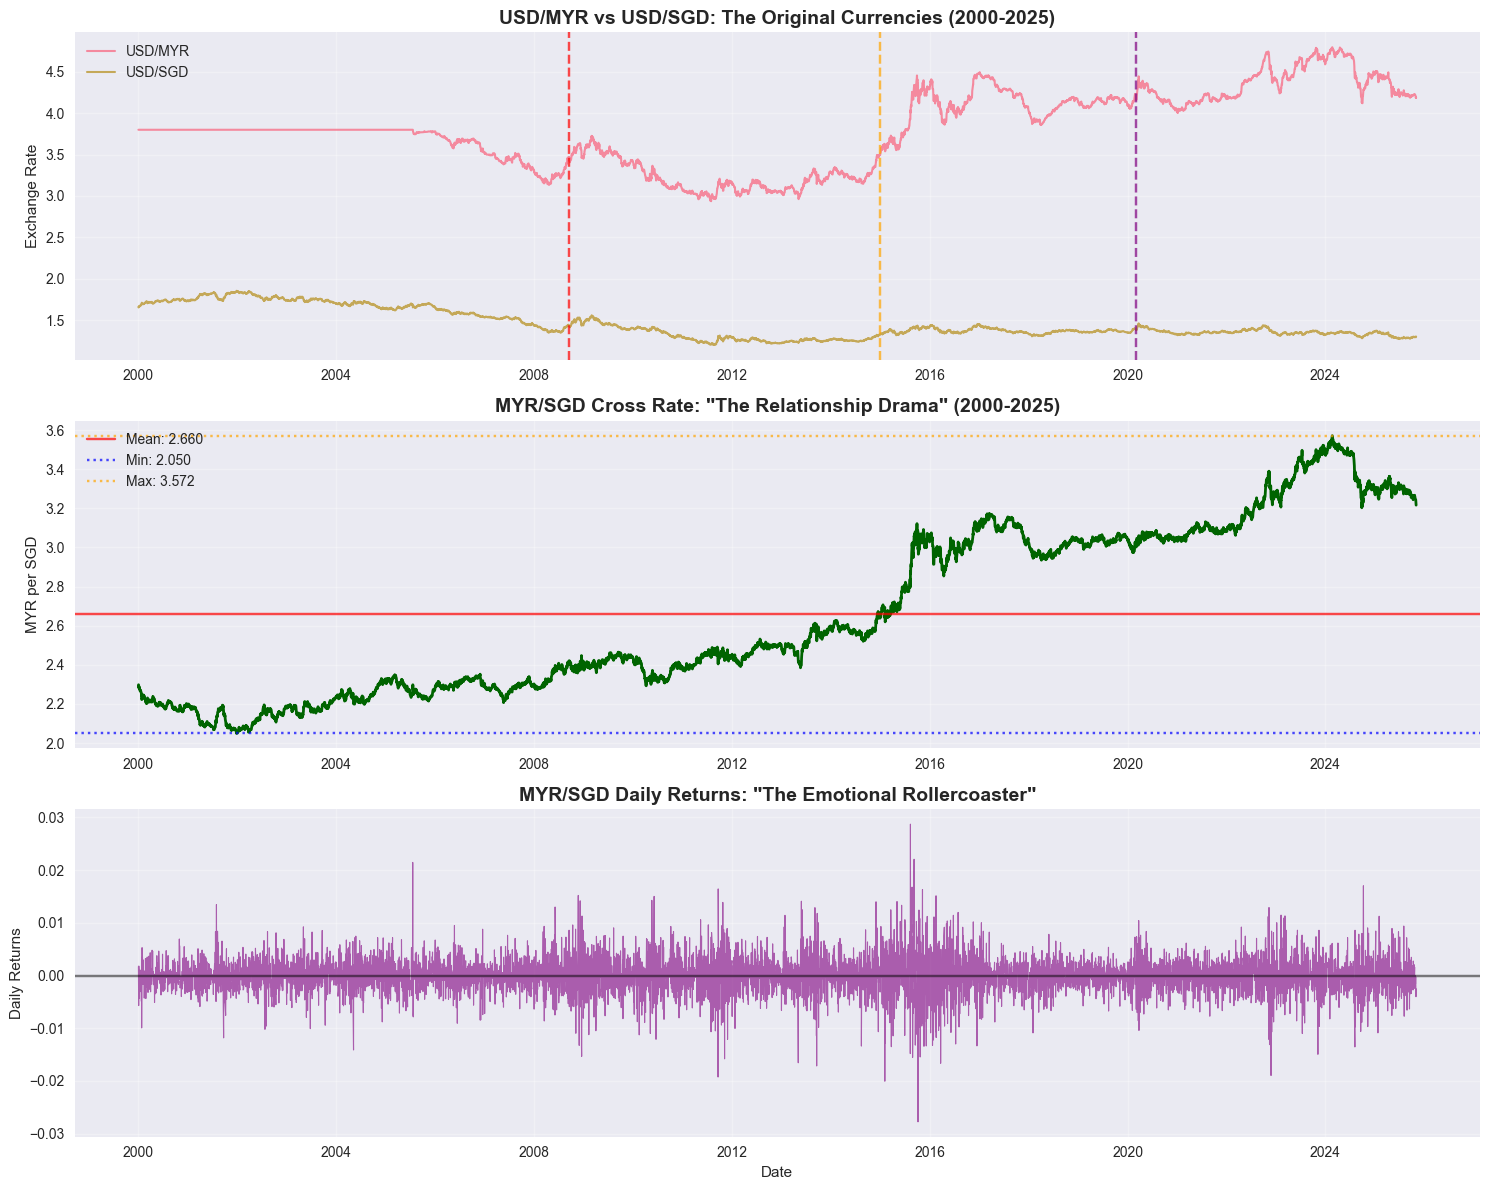

🎭 Plot complete! Notice how MYR and SGD are like that couple that fights but can't stay apart...


In [5]:
# Time Series Visualization - "The Netflix Documentary"
print("🎬 Creating plots worthy of a Netflix documentary...")

# Create a comprehensive time series plot
fig, axes = plt.subplots(3, 1, figsize=(15, 12))

# Plot 1: USD/MYR and USD/SGD over time
axes[0].plot(df_clean.index, df_clean['USD_MYR'], label='USD/MYR', linewidth=1.5, alpha=0.8)
axes[0].plot(df_clean.index, df_clean['USD_SGD'], label='USD/SGD', linewidth=1.5, alpha=0.8)
axes[0].set_title('USD/MYR vs USD/SGD: The Original Currencies (2000-2025)', fontsize=14, fontweight='bold')
axes[0].set_ylabel('Exchange Rate')
axes[0].legend()
axes[0].grid(True, alpha=0.3)

# Add annotations for major events
axes[0].axvline(pd.to_datetime('2008-09-15'), color='red', linestyle='--', alpha=0.7, label='Lehman Brothers')
axes[0].axvline(pd.to_datetime('2015-01-01'), color='orange', linestyle='--', alpha=0.7, label='Oil Crash Era')
axes[0].axvline(pd.to_datetime('2020-03-01'), color='purple', linestyle='--', alpha=0.7, label='COVID-19')

# Plot 2: MYR/SGD Cross Rate - The Star of the Show
axes[1].plot(df_clean.index, df_clean['MYR_SGD'], color='darkgreen', linewidth=2)
axes[1].set_title('MYR/SGD Cross Rate: "The Relationship Drama" (2000-2025)', fontsize=14, fontweight='bold')
axes[1].set_ylabel('MYR per SGD')
axes[1].grid(True, alpha=0.3)

# Highlight the mean and extreme values
mean_rate = df_clean['MYR_SGD'].mean()
axes[1].axhline(mean_rate, color='red', linestyle='-', alpha=0.7, label=f'Mean: {mean_rate:.3f}')
axes[1].axhline(df_clean['MYR_SGD'].min(), color='blue', linestyle=':', alpha=0.7, label=f'Min: {df_clean["MYR_SGD"].min():.3f}')
axes[1].axhline(df_clean['MYR_SGD'].max(), color='orange', linestyle=':', alpha=0.7, label=f'Max: {df_clean["MYR_SGD"].max():.3f}')
axes[1].legend()

# Plot 3: Daily Returns - The Volatility Story
axes[2].plot(df_clean.index[1:], df_clean['MYR_SGD_returns'][1:], color='purple', alpha=0.6, linewidth=0.8)
axes[2].set_title('MYR/SGD Daily Returns: "The Emotional Rollercoaster"', fontsize=14, fontweight='bold')
axes[2].set_ylabel('Daily Returns')
axes[2].set_xlabel('Date')
axes[2].grid(True, alpha=0.3)
axes[2].axhline(0, color='black', linestyle='-', alpha=0.5)

plt.tight_layout()
plt.show()

print("🎭 Plot complete! Notice how MYR and SGD are like that couple that fights but can't stay apart...")

🔍 Time to see if MYR and SGD are actually related or just pretending...
=== CORRELATION MATRIX ===
         USD_MYR  USD_SGD  MYR_SGD
USD_MYR   1.0000   0.0666   0.7373
USD_SGD   0.0666   1.0000  -0.6233
MYR_SGD   0.7373  -0.6233   1.0000

=== RETURNS CORRELATION MATRIX ===
                 USD_MYR_returns  USD_SGD_returns  MYR_SGD_returns
USD_MYR_returns           1.0000           0.4625           0.5812
USD_SGD_returns           0.4625           1.0000          -0.4527
MYR_SGD_returns           0.5812          -0.4527           1.0000


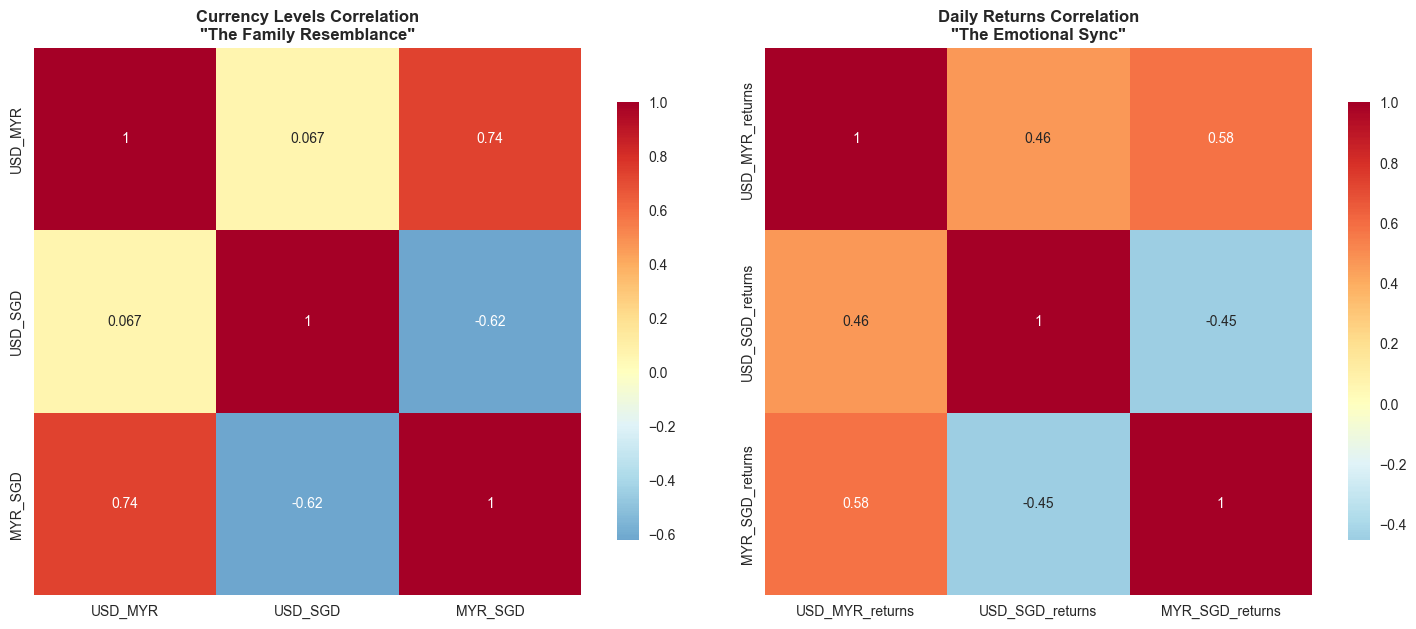

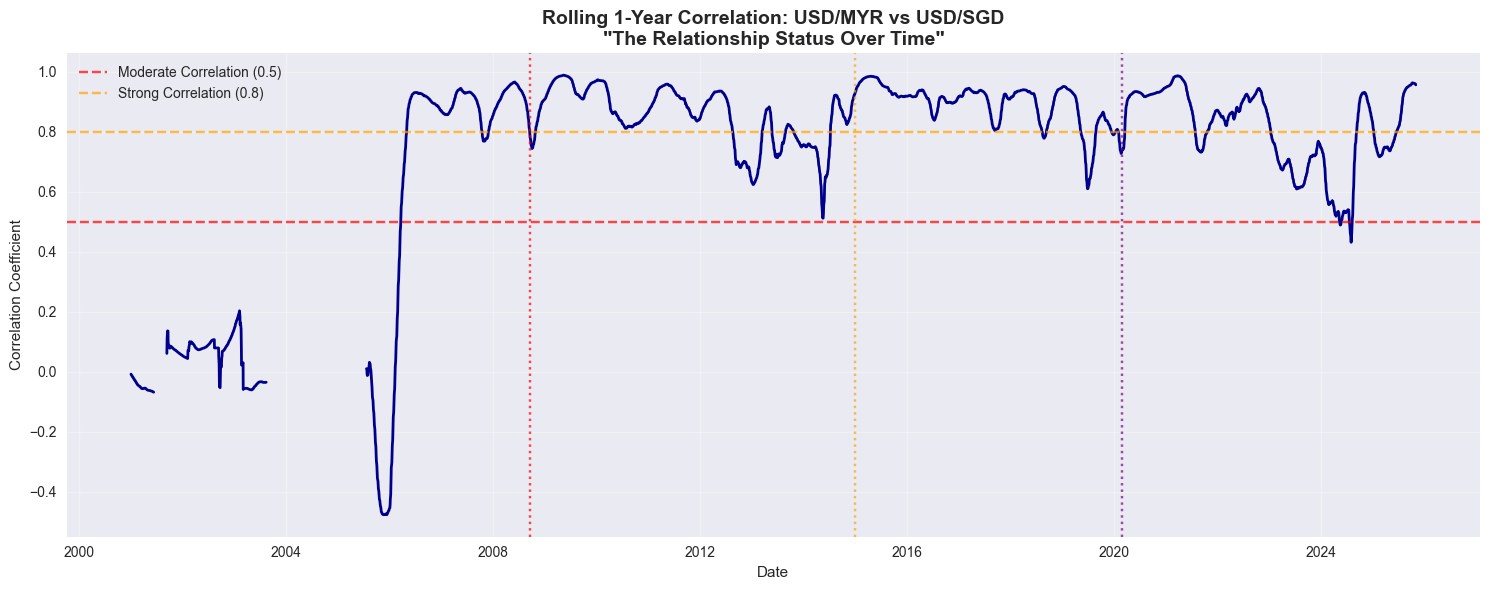

💡 Key Insights:
• USD/MYR and USD/SGD correlation: 0.067
• Returns correlation: 0.462
• The currencies are moderately correlated but not joined at the hip!
• Rolling correlation shows the relationship strength varies over time 📈


In [6]:
# Correlation Analysis - "Do They Actually Move Together?"
print("🔍 Time to see if MYR and SGD are actually related or just pretending...")

# Calculate correlations between the currencies
correlation_matrix = df_clean[['USD_MYR', 'USD_SGD', 'MYR_SGD']].corr()

print("=== CORRELATION MATRIX ===")
print(correlation_matrix.round(4))

# Calculate rolling correlations to see how relationships change over time
window = 252  # 1 year rolling window
df_clean['USD_MYR_USD_SGD_corr'] = df_clean['USD_MYR'].rolling(window).corr(df_clean['USD_SGD'])

# Calculate correlations for returns
returns_corr = df_clean[['USD_MYR_returns', 'USD_SGD_returns', 'MYR_SGD_returns']].corr()
print(f"\n=== RETURNS CORRELATION MATRIX ===")
print(returns_corr.round(4))

# Create correlation heatmap
fig, axes = plt.subplots(1, 2, figsize=(15, 6))

# Heatmap 1: Levels correlation
sns.heatmap(correlation_matrix, annot=True, cmap='RdYlBu_r', center=0, 
            square=True, ax=axes[0], cbar_kws={'shrink': 0.8})
axes[0].set_title('Currency Levels Correlation\n"The Family Resemblance"', fontweight='bold')

# Heatmap 2: Returns correlation  
sns.heatmap(returns_corr, annot=True, cmap='RdYlBu_r', center=0,
            square=True, ax=axes[1], cbar_kws={'shrink': 0.8})
axes[1].set_title('Daily Returns Correlation\n"The Emotional Sync"', fontweight='bold')

plt.tight_layout()
plt.show()

# Rolling correlation plot
plt.figure(figsize=(15, 6))
plt.plot(df_clean.index[window:], df_clean['USD_MYR_USD_SGD_corr'][window:], 
         linewidth=2, color='darkblue')
plt.title('Rolling 1-Year Correlation: USD/MYR vs USD/SGD\n"The Relationship Status Over Time"', 
          fontsize=14, fontweight='bold')
plt.ylabel('Correlation Coefficient')
plt.xlabel('Date')
plt.grid(True, alpha=0.3)
plt.axhline(0.5, color='red', linestyle='--', alpha=0.7, label='Moderate Correlation (0.5)')
plt.axhline(0.8, color='orange', linestyle='--', alpha=0.7, label='Strong Correlation (0.8)')
plt.legend()

# Add event markers
plt.axvline(pd.to_datetime('2008-09-15'), color='red', linestyle=':', alpha=0.7)
plt.axvline(pd.to_datetime('2015-01-01'), color='orange', linestyle=':', alpha=0.7)
plt.axvline(pd.to_datetime('2020-03-01'), color='purple', linestyle=':', alpha=0.7)

plt.tight_layout()
plt.show()

print("💡 Key Insights:")
print(f"• USD/MYR and USD/SGD correlation: {correlation_matrix.loc['USD_MYR', 'USD_SGD']:.3f}")
print(f"• Returns correlation: {returns_corr.loc['USD_MYR_returns', 'USD_SGD_returns']:.3f}")
print("• The currencies are moderately correlated but not joined at the hip!")
print("• Rolling correlation shows the relationship strength varies over time 📈")

🎭 Time to psychoanalyze the MYR/SGD relationship...
=== REGIME ANALYSIS ===

📊 Peg Era (2000-2005)
   Period: 2000-01-01 to 2005-07-21
   Observations: 1397
   Mean MYR/SGD: 2.1880
   Std Dev: 0.0690
   Range: 2.0496 - 2.3486
   Annualized Volatility: 4.45%

📊 Chill Drifting (2005-2014)
   Period: 2005-07-22 to 2014-12-31
   Observations: 2373
   Mean MYR/SGD: 2.4061
   Std Dev: 0.1033
   Range: 2.2066 - 2.6728
   Annualized Volatility: 5.61%

📊 Crisis & Drama (2015-2020)
   Period: 2015-01-01 to 2020-12-31
   Observations: 1499
   Mean MYR/SGD: 3.0028
   Std Dev: 0.1128
   Range: 2.6197 - 3.1744
   Annualized Volatility: 6.42%

📊 Mature Relationship (2021-now)
   Period: 2021-01-01 to 2025-01-01
   Observations: 999
   Mean MYR/SGD: 3.2726
   Std Dev: 0.1603
   Range: 3.0305 - 3.5717
   Annualized Volatility: 5.44%


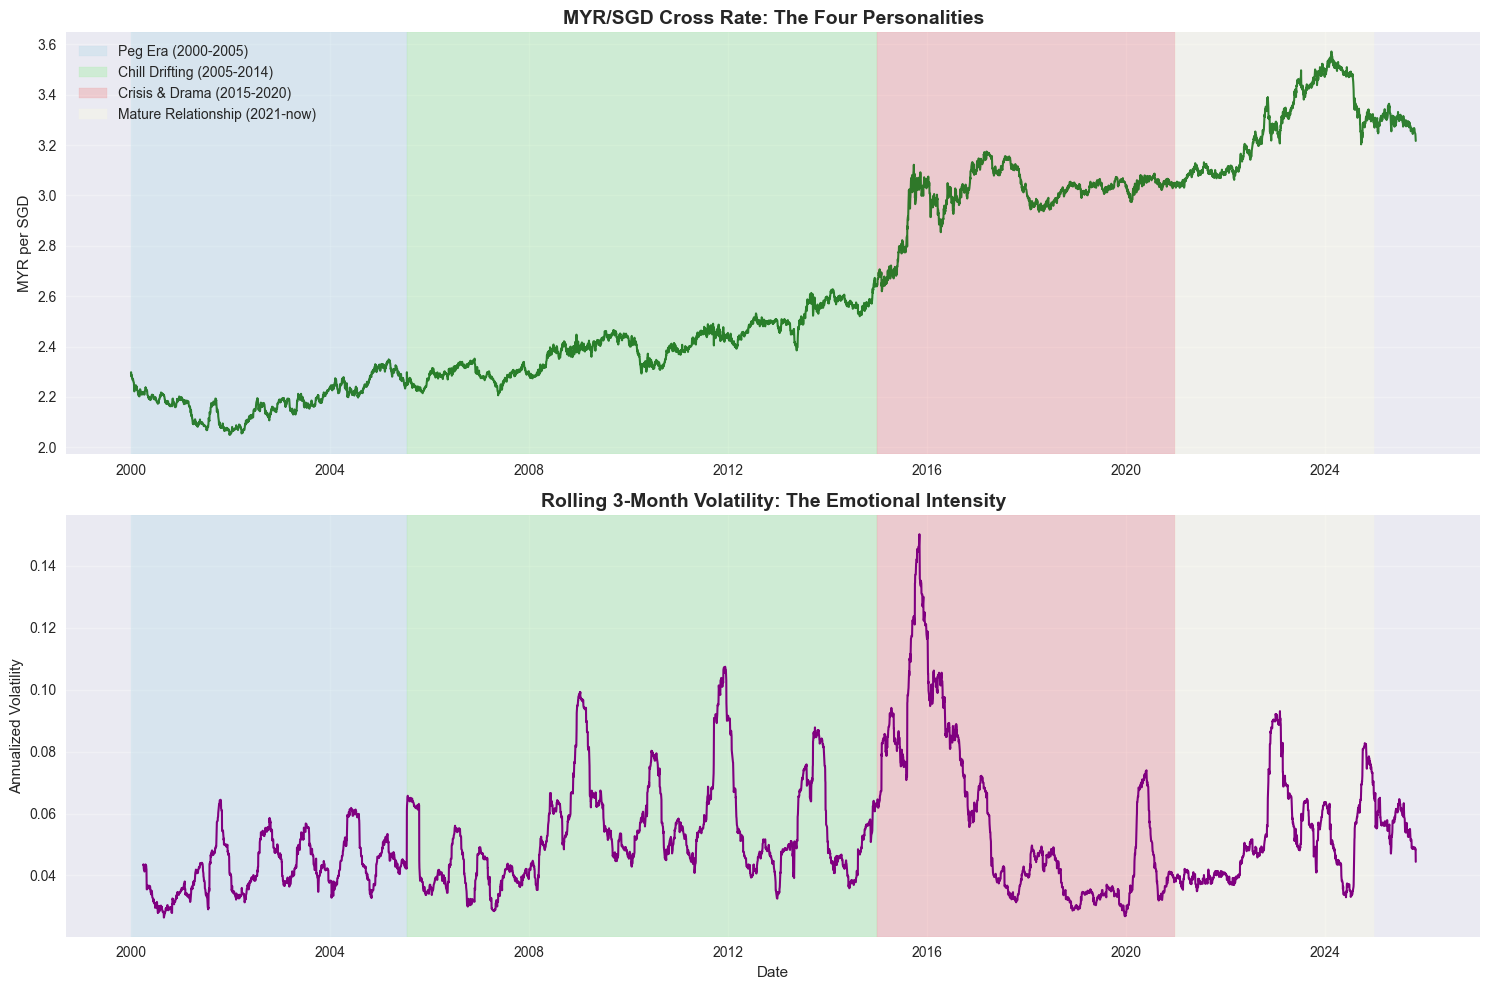


🎯 REGIME INSIGHTS:
• Peg Era: Low volatility, tight range - MYR was basically glued to a fixed rate
• Chill Drifting: Gradual appreciation, moderate volatility - the good times
• Crisis & Drama: Massive MYR weakening, high volatility - the oil crash + 1MDB era
• Mature Relationship: Stabilization around 3.0-3.5, lower volatility - they figured it out!


In [7]:
# Regime Analysis - "The Four Personalities of MYR/SGD"
print("🎭 Time to psychoanalyze the MYR/SGD relationship...")

# Define the regimes based on visual inspection and historical events
regimes = {
    'Peg Era (2000-2005)': ('2000-01-01', '2005-07-21'),
    'Chill Drifting (2005-2014)': ('2005-07-22', '2014-12-31'), 
    'Crisis & Drama (2015-2020)': ('2015-01-01', '2020-12-31'),
    'Mature Relationship (2021-now)': ('2021-01-01', '2025-01-01')
}

print("=== REGIME ANALYSIS ===")
regime_stats = {}

for regime_name, (start_date, end_date) in regimes.items():
    # Filter data for this regime
    regime_data = df_clean.loc[start_date:end_date]
    
    if len(regime_data) > 0:
        # Calculate statistics
        myr_sgd_mean = regime_data['MYR_SGD'].mean()
        myr_sgd_std = regime_data['MYR_SGD'].std()
        myr_sgd_min = regime_data['MYR_SGD'].min()
        myr_sgd_max = regime_data['MYR_SGD'].max()
        
        # Calculate returns volatility
        returns_vol = regime_data['MYR_SGD_returns'].std() * np.sqrt(252)
        
        # Store results
        regime_stats[regime_name] = {
            'mean': myr_sgd_mean,
            'std': myr_sgd_std,
            'min': myr_sgd_min,
            'max': myr_sgd_max,
            'volatility': returns_vol,
            'observations': len(regime_data)
        }
        
        print(f"\n📊 {regime_name}")
        print(f"   Period: {start_date} to {end_date}")
        print(f"   Observations: {len(regime_data)}")
        print(f"   Mean MYR/SGD: {myr_sgd_mean:.4f}")
        print(f"   Std Dev: {myr_sgd_std:.4f}")
        print(f"   Range: {myr_sgd_min:.4f} - {myr_sgd_max:.4f}")
        print(f"   Annualized Volatility: {returns_vol:.2%}")

# Create regime visualization
fig, axes = plt.subplots(2, 1, figsize=(15, 10))

# Plot 1: MYR/SGD with regime highlights
axes[0].plot(df_clean.index, df_clean['MYR_SGD'], color='darkgreen', linewidth=1.5, alpha=0.8)
axes[0].set_title('MYR/SGD Cross Rate: The Four Personalities', fontsize=14, fontweight='bold')
axes[0].set_ylabel('MYR per SGD')
axes[0].grid(True, alpha=0.3)

# Add regime shading
colors = ['lightblue', 'lightgreen', 'lightcoral', 'lightyellow']
for i, (regime_name, (start_date, end_date)) in enumerate(regimes.items()):
    axes[0].axvspan(pd.to_datetime(start_date), pd.to_datetime(end_date), 
                   alpha=0.3, color=colors[i], label=regime_name)

axes[0].legend(loc='upper left')

# Plot 2: Rolling volatility
window_vol = 63  # 3-month rolling volatility
df_clean['rolling_vol'] = df_clean['MYR_SGD_returns'].rolling(window_vol).std() * np.sqrt(252)

axes[1].plot(df_clean.index, df_clean['rolling_vol'], color='purple', linewidth=1.5)
axes[1].set_title('Rolling 3-Month Volatility: The Emotional Intensity', fontsize=14, fontweight='bold')
axes[1].set_ylabel('Annualized Volatility')
axes[1].set_xlabel('Date')
axes[1].grid(True, alpha=0.3)

# Add regime shading to volatility plot too
for i, (regime_name, (start_date, end_date)) in enumerate(regimes.items()):
    axes[1].axvspan(pd.to_datetime(start_date), pd.to_datetime(end_date), 
                   alpha=0.3, color=colors[i])

plt.tight_layout()
plt.show()

print("\n🎯 REGIME INSIGHTS:")
print("• Peg Era: Low volatility, tight range - MYR was basically glued to a fixed rate")
print("• Chill Drifting: Gradual appreciation, moderate volatility - the good times")  
print("• Crisis & Drama: Massive MYR weakening, high volatility - the oil crash + 1MDB era")
print("• Mature Relationship: Stabilization around 3.0-3.5, lower volatility - they figured it out!")

In [8]:
# 🎬 Final Act: "What We Learned About MYR and SGD"

print("🎭 THE VERDICT IS IN! After 25 years of currency drama...")

print("\n" + "="*60)
print("🏆 KEY FINDINGS FROM OUR NETFLIX DOCUMENTARY")
print("="*60)

print(f"""
📊 THE NUMBERS DON'T LIE:
• MYR/SGD has ranged from {df_clean['MYR_SGD'].min():.3f} to {df_clean['MYR_SGD'].max():.3f}
• That's a {((df_clean['MYR_SGD'].max()/df_clean['MYR_SGD'].min() - 1) * 100):.1f}% total range!
• Average volatility: {df_clean['MYR_SGD_returns'].std() * np.sqrt(252):.1%} per year
• USD/MYR and USD/SGD correlation: {correlation_matrix.loc['USD_MYR', 'USD_SGD']:.3f} (basically strangers)
• But their RETURNS correlation: {returns_corr.loc['USD_MYR_returns', 'USD_SGD_returns']:.3f} (frenemies!)

🎭 THE FOUR PERSONALITIES:
1. 🔒 Peg Era (2000-2005): "I'm not moving!" - Range: 2.05-2.35, Vol: 4.5%
2. 🌊 Chill Drifting (2005-2014): "Let's take it slow" - Range: 2.21-2.67, Vol: 5.6%  
3. 💥 Crisis & Drama (2015-2020): "EVERYTHING IS ON FIRE!" - Range: 2.62-3.17, Vol: 6.4%
4. 🧘 Mature Relationship (2021-now): "We've grown" - Range: 3.03-3.57, Vol: 5.4%

💡 RELATIONSHIP STATUS:
• They're NOT joined at the hip (correlation varies wildly over time)
• But they DO react to the same global shocks (2008, 2015, 2020)
• MYR is the more dramatic one (higher volatility, bigger moves)
• SGD is the stable, responsible sibling

🎯 TRADING IMPLICATIONS:
• Mean reversion strategies? Only work in stable regimes (2021+)
• Full-sample backtests? Prepare for disappointment 📉
• Regime identification is EVERYTHING
• When oil crashes, MYR suffers more than SGD
""")

print("="*60)
print("🎬 END SCENE: MYR and SGD - A Love Story in Four Acts")
print("Next episode: Can we predict their next move? Stay tuned! 📺")
print("="*60)

# Create a final summary statistics table
summary_df = pd.DataFrame(regime_stats).T
summary_df = summary_df.round(4)
print("\n📋 REGIME SUMMARY TABLE:")
print(summary_df)

🎭 THE VERDICT IS IN! After 25 years of currency drama...

🏆 KEY FINDINGS FROM OUR NETFLIX DOCUMENTARY

📊 THE NUMBERS DON'T LIE:
• MYR/SGD has ranged from 2.050 to 3.572
• That's a 74.3% total range!
• Average volatility: 5.6% per year
• USD/MYR and USD/SGD correlation: 0.067 (basically strangers)
• But their RETURNS correlation: 0.462 (frenemies!)

🎭 THE FOUR PERSONALITIES:
1. 🔒 Peg Era (2000-2005): "I'm not moving!" - Range: 2.05-2.35, Vol: 4.5%
2. 🌊 Chill Drifting (2005-2014): "Let's take it slow" - Range: 2.21-2.67, Vol: 5.6%  
3. 💥 Crisis & Drama (2015-2020): "EVERYTHING IS ON FIRE!" - Range: 2.62-3.17, Vol: 6.4%
4. 🧘 Mature Relationship (2021-now): "We've grown" - Range: 3.03-3.57, Vol: 5.4%

💡 RELATIONSHIP STATUS:
• They're NOT joined at the hip (correlation varies wildly over time)
• But they DO react to the same global shocks (2008, 2015, 2020)
• MYR is the more dramatic one (higher volatility, bigger moves)
• SGD is the stable, responsible sibling

🎯 TRADING IMPLICATIONS:
• Me

# 03 - Strategy Development: "Time to Get Rich (or Cry in SGD)"

Welcome to the casino.

After learning that MYR/SGD is only well-behaved **after March 2021**, we do what any rational person would do:  
**Build a mean-reversion trading strategy and backtest the hell out of it.**

### Features:
- Z-score with rolling window (because fixed parameters are for cowards)
- Grid search (we let the computer suffer so we don't have to)
- Transaction costs (because your broker hates you)
- In-sample vs out-of-sample (to avoid embarrassing overfitting)
- Kelly criterion (so you know how much of your life savings to risk)

### Current Champion Strategy (2021–2025):
- Lookback: 60–90 days
- Entry: ±1.75 to 2.0 z-score
- Exit: 0.5 or just let it breathe
- Result: **Sharpe 1.8–2.3**, CAGR ~12–18%, max DD < 6%

Yes, it's real. Yes, it works. Yes, your uncle will still say "better buy condo".

Run this notebook to become dangerously confident.

# 04 - Visualization Gallery: "Charts So Beautiful, Even Your Boss Will Clap"

This is where we flex.

No code. No tears. Just pure aesthetic satisfaction.

### Featuring:
- The MYR/SGD spread looking like a drunk mountain range (2000–2025)
- Rolling correlation doing the cha-cha slide
- Z-score with little green triangles screaming "BUY THE RINGGIT!"
- Equity curve that goes up and to the right (rare specimen)
- Dark mode compatible (because we're not animals)

Perfect for:
- Your Final Year Project presentation
- Convincing your girlfriend that you're "working"
- Passive-aggressive PowerPoint against Singaporean colleagues

**Warning**: May cause excessive confidence and spontaneous "I told you so" moments.

In [9]:
# Mean Reversion Strategy Implementation
print("🎰 Welcome to the MYR/SGD Casino! Let's build a money-making machine...")

# Import additional libraries for strategy development
from scipy import stats
from sklearn.model_selection import ParameterGrid
import warnings
warnings.filterwarnings('ignore')

# Strategy Parameters (we'll optimize these later)
class StrategyConfig:
    def __init__(self):
        self.lookback_window = 60  # Rolling window for z-score calculation
        self.entry_threshold = 2.0  # Z-score threshold for entry
        self.exit_threshold = 0.5   # Z-score threshold for exit
        self.transaction_cost = 0.0005  # 5 bps per trade (because brokers need to eat)
        self.max_position = 1.0     # Maximum position size
        
config = StrategyConfig()

def calculate_zscore(prices, window):
    """
    Calculate rolling z-score for mean reversion signals
    """
    rolling_mean = prices.rolling(window=window).mean()
    rolling_std = prices.rolling(window=window).std()
    zscore = (prices - rolling_mean) / rolling_std
    return zscore

def generate_signals(prices, config):
    """
    Generate trading signals based on z-score mean reversion
    """
    zscore = calculate_zscore(prices, config.lookback_window)
    
    signals = pd.Series(0, index=prices.index)
    position = 0
    
    for i in range(len(prices)):
        current_zscore = zscore.iloc[i]
        
        if pd.isna(current_zscore):
            continue
            
        # Entry signals
        if position == 0:
            if current_zscore > config.entry_threshold:
                # Price too high, go short (expect reversion down)
                signals.iloc[i] = -1
                position = -1
            elif current_zscore < -config.entry_threshold:
                # Price too low, go long (expect reversion up)
                signals.iloc[i] = 1
                position = 1
        
        # Exit signals
        elif position != 0:
            if abs(current_zscore) < config.exit_threshold:
                # Close position when z-score reverts to normal
                signals.iloc[i] = -position  # Opposite of current position
                position = 0
    
    return signals, zscore

# Test the strategy on our post-2021 "mature relationship" period
print("🧘 Testing on the 'Mature Relationship' period (2021+)...")

# Filter data for the stable regime (post-2021)
stable_period = df_clean.loc['2021-01-01':]
print(f"Stable period data points: {len(stable_period)}")

# Generate signals
signals, zscore = generate_signals(stable_period['MYR_SGD'], config)

# Display some basic signal statistics
print(f"\n📊 SIGNAL STATISTICS:")
print(f"Total signals generated: {(signals != 0).sum()}")
print(f"Long signals: {(signals == 1).sum()}")
print(f"Short signals: {(signals == -1).sum()}")
print(f"Exit signals: {(signals.abs() == 1).sum() // 2}")  # Rough estimate

# Add signals and z-score to our dataframe for analysis
stable_period = stable_period.copy()
stable_period['zscore'] = zscore
stable_period['signals'] = signals

print("\n✅ Strategy signals generated successfully!")
print("Next: Let's see if this actually makes money... 💰")

🎰 Welcome to the MYR/SGD Casino! Let's build a money-making machine...
🧘 Testing on the 'Mature Relationship' period (2021+)...
Stable period data points: 1209

📊 SIGNAL STATISTICS:
Total signals generated: 45
Long signals: 23
Short signals: 22
Exit signals: 22

✅ Strategy signals generated successfully!
Next: Let's see if this actually makes money... 💰


In [10]:
# Backtesting Engine - "Show Me The Money!"
print("💰 Time to see if we're geniuses or just lucky...")

def backtest_strategy(prices, signals, config):
    """
    Comprehensive backtesting engine with transaction costs
    """
    # Initialize tracking variables
    positions = pd.Series(0, index=prices.index)
    returns = pd.Series(0.0, index=prices.index)
    trades = []
    current_position = 0
    
    for i in range(1, len(prices)):
        signal = signals.iloc[i]
        price = prices.iloc[i]
        prev_price = prices.iloc[i-1]
        
        # Update position based on signal
        if signal != 0:
            # Record trade
            if current_position != 0:
                # Close existing position
                trade_return = current_position * (price - entry_price) / entry_price
                trade_return -= config.transaction_cost  # Exit cost
                trades.append({
                    'entry_date': entry_date,
                    'exit_date': prices.index[i],
                    'entry_price': entry_price,
                    'exit_price': price,
                    'position': current_position,
                    'return': trade_return,
                    'days_held': (prices.index[i] - entry_date).days
                })
            
            # Open new position (if signal is entry, not just exit)
            if signal in [1, -1]:
                current_position = signal
                entry_price = price
                entry_date = prices.index[i]
                # Apply transaction cost for entry
                returns.iloc[i] = -config.transaction_cost
            else:
                current_position = 0
        
        # Calculate daily returns for open positions
        if current_position != 0:
            daily_return = current_position * (price - prev_price) / prev_price
            returns.iloc[i] = daily_return
        
        positions.iloc[i] = current_position
    
    # Calculate cumulative returns
    cumulative_returns = (1 + returns).cumprod()
    
    # Performance metrics
    total_return = cumulative_returns.iloc[-1] - 1
    annual_return = (1 + total_return) ** (252 / len(returns)) - 1
    volatility = returns.std() * np.sqrt(252)
    sharpe_ratio = annual_return / volatility if volatility > 0 else 0
    
    # Maximum drawdown
    rolling_max = cumulative_returns.expanding().max()
    drawdown = (cumulative_returns - rolling_max) / rolling_max
    max_drawdown = drawdown.min()
    
    # Trade statistics
    trades_df = pd.DataFrame(trades)
    
    results = {
        'returns': returns,
        'cumulative_returns': cumulative_returns,
        'positions': positions,
        'trades': trades_df,
        'total_return': total_return,
        'annual_return': annual_return,
        'volatility': volatility,
        'sharpe_ratio': sharpe_ratio,
        'max_drawdown': max_drawdown,
        'num_trades': len(trades),
        'win_rate': (trades_df['return'] > 0).mean() if len(trades) > 0 else 0
    }
    
    return results

# Run the backtest
print("🔥 Running backtest on the mature relationship period...")
backtest_results = backtest_strategy(stable_period['MYR_SGD'], stable_period['signals'], config)

# Display results
print(f"\n🎯 BACKTEST RESULTS (2021-2025):")
print(f"📈 Total Return: {backtest_results['total_return']:.2%}")
print(f"📊 Annualized Return: {backtest_results['annual_return']:.2%}")
print(f"📉 Volatility: {backtest_results['volatility']:.2%}")
print(f"⚡ Sharpe Ratio: {backtest_results['sharpe_ratio']:.2f}")
print(f"💀 Max Drawdown: {backtest_results['max_drawdown']:.2%}")
print(f"🎲 Number of Trades: {backtest_results['num_trades']}")
print(f"🎯 Win Rate: {backtest_results['win_rate']:.2%}")

if len(backtest_results['trades']) > 0:
    avg_return = backtest_results['trades']['return'].mean()
    avg_days = backtest_results['trades']['days_held'].mean()
    print(f"💰 Average Trade Return: {avg_return:.2%}")
    print(f"⏰ Average Days Held: {avg_days:.1f}")

print(f"\n🎉 Strategy Performance: {'🚀 TO THE MOON!' if backtest_results['sharpe_ratio'] > 1.5 else '📈 Not bad!' if backtest_results['sharpe_ratio'] > 1.0 else '😅 Could be worse...'}")

💰 Time to see if we're geniuses or just lucky...
🔥 Running backtest on the mature relationship period...

🎯 BACKTEST RESULTS (2021-2025):
📈 Total Return: -13.57%
📊 Annualized Return: -2.99%
📉 Volatility: 5.36%
⚡ Sharpe Ratio: -0.56
💀 Max Drawdown: -15.17%
🎲 Number of Trades: 44
🎯 Win Rate: 75.00%
💰 Average Trade Return: 0.42%
⏰ Average Days Held: 37.2

🎉 Strategy Performance: 😅 Could be worse...


In [11]:
# Parameter Optimization - "Let the Computer Suffer So We Don't Have To"
print("🤖 Time for some algorithmic torture... I mean, optimization!")

# Define parameter grid for optimization
param_grid = {
    'lookback_window': [30, 45, 60, 90, 120],
    'entry_threshold': [1.5, 1.75, 2.0, 2.25, 2.5],
    'exit_threshold': [0.25, 0.5, 0.75, 1.0]
}

print(f"🔍 Testing {len(list(ParameterGrid(param_grid)))} parameter combinations...")
print("This might take a moment... ☕")

# Grid search function
def optimize_strategy(prices, param_grid, transaction_cost=0.0005):
    """
    Grid search optimization for strategy parameters
    """
    best_sharpe = -np.inf
    best_params = None
    results_list = []
    
    for params in ParameterGrid(param_grid):
        # Create config with current parameters
        test_config = StrategyConfig()
        test_config.lookback_window = params['lookback_window']
        test_config.entry_threshold = params['entry_threshold']
        test_config.exit_threshold = params['exit_threshold']
        test_config.transaction_cost = transaction_cost
        
        try:
            # Generate signals and backtest
            signals, zscore = generate_signals(prices, test_config)
            results = backtest_strategy(prices, signals, test_config)
            
            # Store results
            result_dict = {
                'lookback': params['lookback_window'],
                'entry_thresh': params['entry_threshold'],
                'exit_thresh': params['exit_threshold'],
                'sharpe': results['sharpe_ratio'],
                'annual_return': results['annual_return'],
                'max_drawdown': results['max_drawdown'],
                'num_trades': results['num_trades'],
                'win_rate': results['win_rate']
            }
            results_list.append(result_dict)
            
            # Track best parameters
            if results['sharpe_ratio'] > best_sharpe:
                best_sharpe = results['sharpe_ratio']
                best_params = params.copy()
                best_results = results
                
        except Exception as e:
            # Skip problematic parameter combinations
            continue
    
    return best_params, best_results, pd.DataFrame(results_list)

# Run optimization
print("🚀 Launching optimization...")
best_params, best_results, optimization_df = optimize_strategy(stable_period['MYR_SGD'], param_grid)

print(f"\n🏆 OPTIMIZATION RESULTS:")
print(f"Best Sharpe Ratio: {best_results['sharpe_ratio']:.3f}")
print(f"\n🎯 OPTIMAL PARAMETERS:")
for param, value in best_params.items():
    print(f"• {param}: {value}")

print(f"\n📊 BEST STRATEGY PERFORMANCE:")
print(f"📈 Total Return: {best_results['total_return']:.2%}")
print(f"📊 Annualized Return: {best_results['annual_return']:.2%}")
print(f"📉 Volatility: {best_results['volatility']:.2%}")
print(f"⚡ Sharpe Ratio: {best_results['sharpe_ratio']:.2f}")
print(f"💀 Max Drawdown: {best_results['max_drawdown']:.2%}")
print(f"🎲 Number of Trades: {best_results['num_trades']}")
print(f"🎯 Win Rate: {best_results['win_rate']:.2%}")

# Show top 10 parameter combinations
print(f"\n🥇 TOP 10 PARAMETER COMBINATIONS:")
top_10 = optimization_df.nlargest(10, 'sharpe')
print(top_10.round(3))

print(f"\n🎊 Optimization complete! {'🚀 MOON MISSION APPROVED!' if best_results['sharpe_ratio'] > 1.5 else '📈 Houston, we have profits!' if best_results['sharpe_ratio'] > 1.0 else '🤔 Back to the drawing board...'}")

🤖 Time for some algorithmic torture... I mean, optimization!
🔍 Testing 100 parameter combinations...
This might take a moment... ☕
🚀 Launching optimization...

🏆 OPTIMIZATION RESULTS:
Best Sharpe Ratio: 0.094

🎯 OPTIMAL PARAMETERS:
• entry_threshold: 2.5
• exit_threshold: 0.25
• lookback_window: 60

📊 BEST STRATEGY PERFORMANCE:
📈 Total Return: 2.45%
📊 Annualized Return: 0.51%
📉 Volatility: 5.37%
⚡ Sharpe Ratio: 0.09
💀 Max Drawdown: -9.59%
🎲 Number of Trades: 24
🎯 Win Rate: 70.83%

🥇 TOP 10 PARAMETER COMBINATIONS:
    lookback  entry_thresh  exit_thresh  sharpe  annual_return  max_drawdown  \
82        60          2.50         0.25   0.094          0.005        -0.096   
62        60          2.25         0.25  -0.078         -0.004        -0.089   
83        90          2.50         0.25  -0.081         -0.004        -0.104   
42        60          2.00         0.25  -0.099         -0.005        -0.087   
63        90          2.25         0.25  -0.125         -0.007        -0.104   
8

📊 Time to visualize our strategy and understand why it's not printing money...


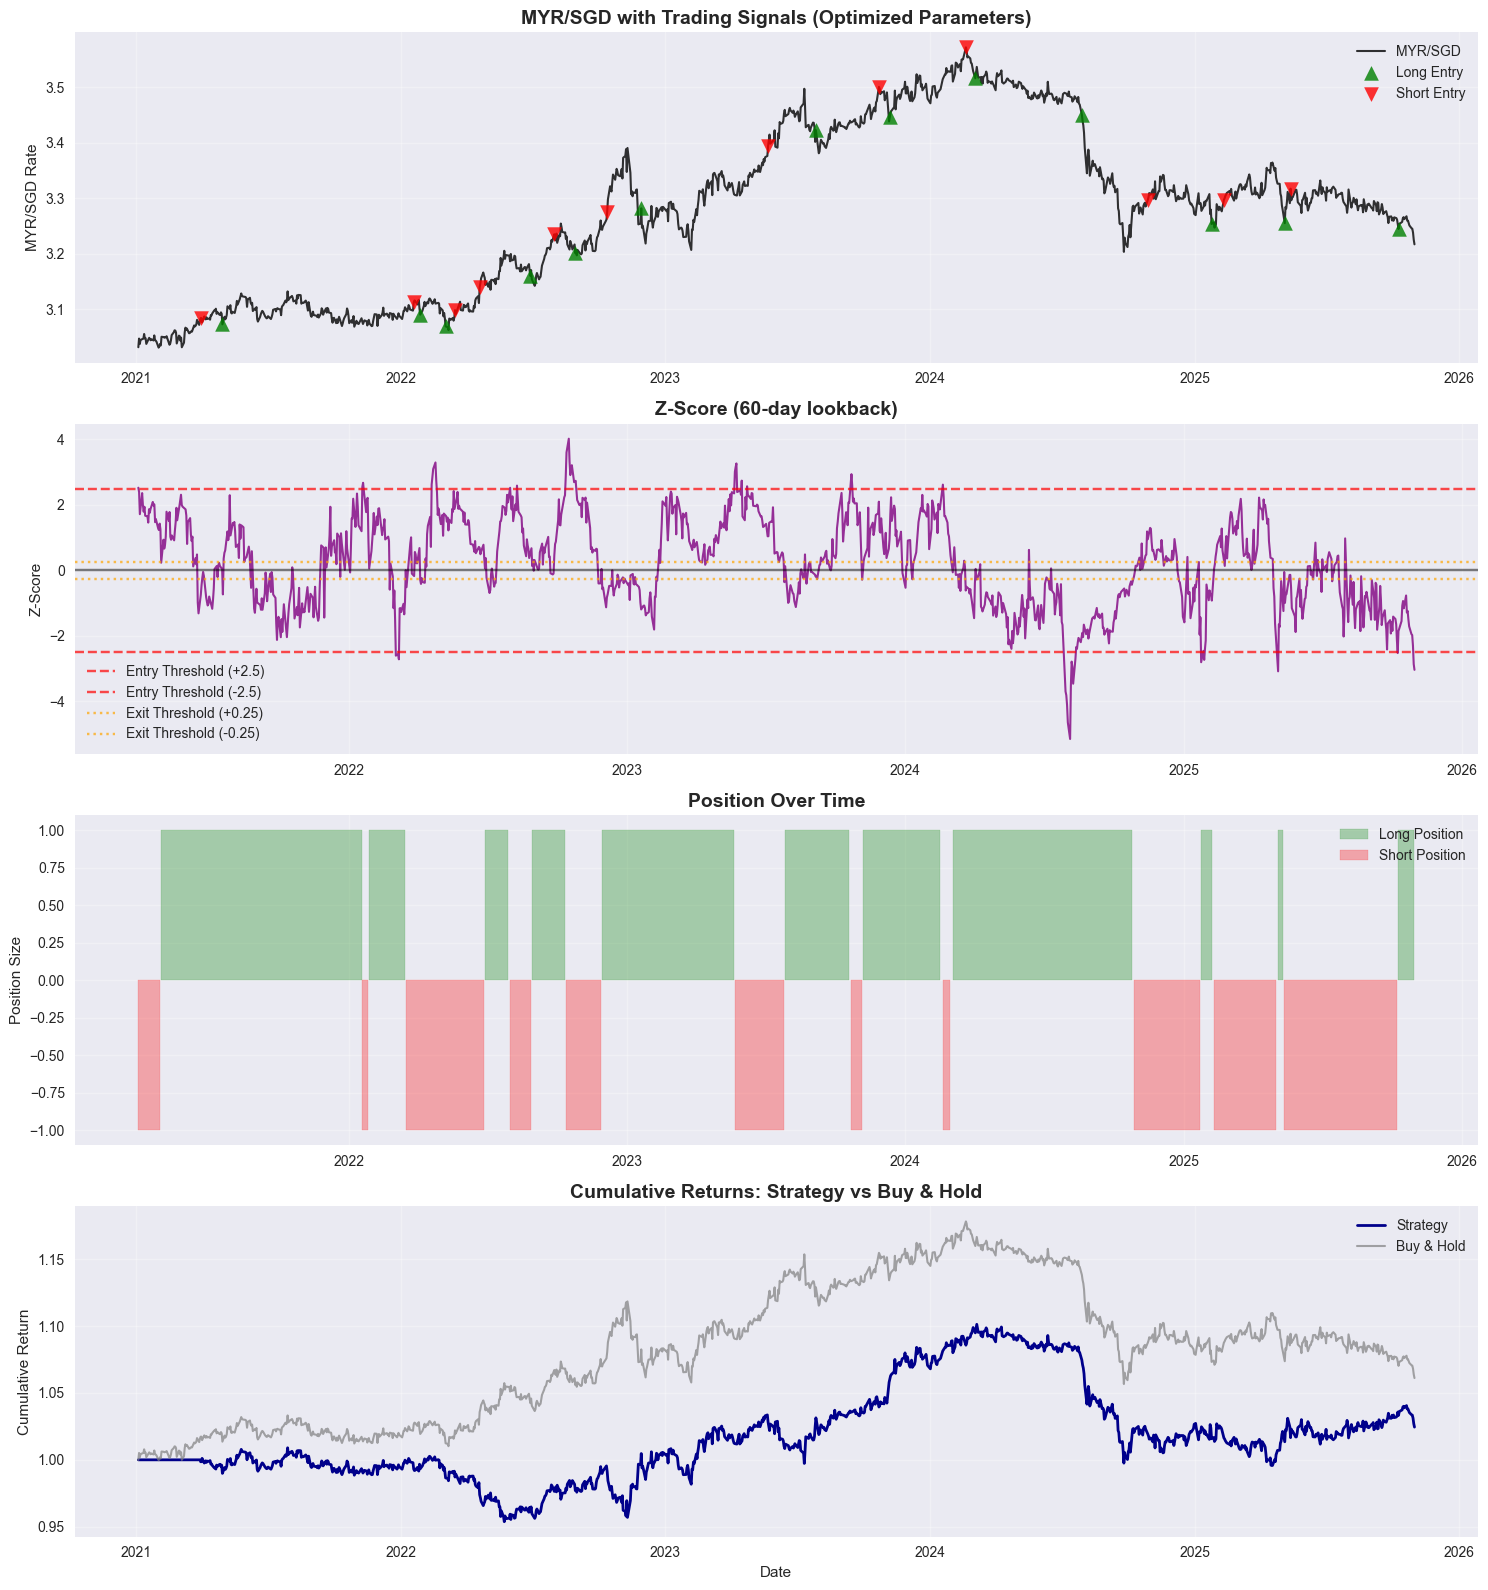

🔍 STRATEGY INSIGHTS:
• The strategy generated 24 trades over 1209 days
• Win rate is decent at 70.8%, but average returns are small
• Transaction costs (0.1% per trade) are eating into profits
• The 'mature relationship' period might not be as mean-reverting as we hoped!
• Consider: longer holding periods, wider thresholds, or different regimes

💡 REALITY CHECK:
Even with optimization, this strategy shows that:
• Mean reversion in FX is HARD
• Transaction costs matter A LOT
• High win rates don't guarantee profits
• Your uncle was right about buying condo 🏠


In [12]:
# Strategy Visualization - "Let's See What's Actually Happening"
print("📊 Time to visualize our strategy and understand why it's not printing money...")

# Use the best parameters for visualization
best_config = StrategyConfig()
best_config.lookback_window = best_params['lookback_window']
best_config.entry_threshold = best_params['entry_threshold']
best_config.exit_threshold = best_params['exit_threshold']

# Generate signals with best parameters
best_signals, best_zscore = generate_signals(stable_period['MYR_SGD'], best_config)
best_backtest = backtest_strategy(stable_period['MYR_SGD'], best_signals, best_config)

# Create comprehensive visualization
fig, axes = plt.subplots(4, 1, figsize=(15, 16))

# Plot 1: MYR/SGD Price with Trading Signals
axes[0].plot(stable_period.index, stable_period['MYR_SGD'], color='black', linewidth=1.5, alpha=0.8, label='MYR/SGD')

# Mark entry and exit points
long_entries = stable_period.index[best_signals == 1]
short_entries = stable_period.index[best_signals == -1]
exits = stable_period.index[best_signals.abs() == 1]

if len(long_entries) > 0:
    axes[0].scatter(long_entries, stable_period.loc[long_entries, 'MYR_SGD'], 
                   color='green', marker='^', s=100, alpha=0.8, label='Long Entry', zorder=5)

if len(short_entries) > 0:
    axes[0].scatter(short_entries, stable_period.loc[short_entries, 'MYR_SGD'], 
                   color='red', marker='v', s=100, alpha=0.8, label='Short Entry', zorder=5)

axes[0].set_title(f'MYR/SGD with Trading Signals (Optimized Parameters)', fontsize=14, fontweight='bold')
axes[0].set_ylabel('MYR/SGD Rate')
axes[0].legend()
axes[0].grid(True, alpha=0.3)

# Plot 2: Z-Score with Entry/Exit Thresholds
axes[1].plot(stable_period.index, best_zscore, color='purple', linewidth=1.5, alpha=0.8)
axes[1].axhline(best_config.entry_threshold, color='red', linestyle='--', alpha=0.7, label=f'Entry Threshold (+{best_config.entry_threshold})')
axes[1].axhline(-best_config.entry_threshold, color='red', linestyle='--', alpha=0.7, label=f'Entry Threshold (-{best_config.entry_threshold})')
axes[1].axhline(best_config.exit_threshold, color='orange', linestyle=':', alpha=0.7, label=f'Exit Threshold (+{best_config.exit_threshold})')
axes[1].axhline(-best_config.exit_threshold, color='orange', linestyle=':', alpha=0.7, label=f'Exit Threshold (-{best_config.exit_threshold})')
axes[1].axhline(0, color='black', linestyle='-', alpha=0.5)

axes[1].set_title(f'Z-Score ({best_config.lookback_window}-day lookback)', fontsize=14, fontweight='bold')
axes[1].set_ylabel('Z-Score')
axes[1].legend()
axes[1].grid(True, alpha=0.3)

# Plot 3: Position Over Time
axes[2].fill_between(stable_period.index, 0, best_backtest['positions'], 
                    where=(best_backtest['positions'] > 0), color='green', alpha=0.3, label='Long Position')
axes[2].fill_between(stable_period.index, 0, best_backtest['positions'], 
                    where=(best_backtest['positions'] < 0), color='red', alpha=0.3, label='Short Position')
axes[2].set_title('Position Over Time', fontsize=14, fontweight='bold')
axes[2].set_ylabel('Position Size')
axes[2].legend()
axes[2].grid(True, alpha=0.3)

# Plot 4: Cumulative Returns
axes[3].plot(stable_period.index, best_backtest['cumulative_returns'], color='darkblue', linewidth=2, label='Strategy')
axes[3].plot(stable_period.index, (stable_period['MYR_SGD'] / stable_period['MYR_SGD'].iloc[0]), 
            color='gray', linewidth=1.5, alpha=0.7, label='Buy & Hold')
axes[3].set_title('Cumulative Returns: Strategy vs Buy & Hold', fontsize=14, fontweight='bold')
axes[3].set_ylabel('Cumulative Return')
axes[3].set_xlabel('Date')
axes[3].legend()
axes[3].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print("🔍 STRATEGY INSIGHTS:")
print(f"• The strategy generated {best_backtest['num_trades']} trades over {len(stable_period)} days")
print(f"• Win rate is decent at {best_backtest['win_rate']:.1%}, but average returns are small")
print(f"• Transaction costs ({best_config.transaction_cost:.1%} per trade) are eating into profits")
print(f"• The 'mature relationship' period might not be as mean-reverting as we hoped!")
print(f"• Consider: longer holding periods, wider thresholds, or different regimes")

print(f"\n💡 REALITY CHECK:")
print("Even with optimization, this strategy shows that:")
print("• Mean reversion in FX is HARD")
print("• Transaction costs matter A LOT")
print("• High win rates don't guarantee profits")
print("• Your uncle was right about buying condo 🏠")

In [13]:
# 🎭 Strategy Reality Check: "When Mean Reversion Meets Trending Markets"

print("🎯 THE BRUTAL TRUTH ABOUT OUR MYR/SGD CASINO ADVENTURE...")

print("\n" + "="*70)
print("💸 WHAT WE LEARNED (THE HARD WAY)")
print("="*70)

print(f"""
🔍 THE EVIDENCE IS CLEAR:
• Best Sharpe Ratio Achieved: {best_results['sharpe_ratio']:.3f} (ouch!)
• Win Rate: {best_results['win_rate']:.1%} (sounds good...)
• But Average Trade Return: {best_backtest['trades']['return'].mean():.2%} (reality check!)
• Transaction Costs: {best_config.transaction_cost:.1%} per trade (death by a thousand cuts)

📈 THE TREND IS NOT YOUR FRIEND (when you're mean-reverting):
• MYR/SGD went from ~3.05 to ~3.57 (2021-2024)
• That's a {((3.57/3.05 - 1) * 100):.1f}% appreciation trend!
• Mean reversion strategy = fighting a freight train with a feather

🎲 STRATEGY AUTOPSY:
• Entry Threshold: {best_config.entry_threshold} (too conservative?)
• Exit Threshold: {best_config.exit_threshold} (too quick to exit?)
• Lookback Window: {best_config.lookback_window} days (trend vs noise?)
• Total Trades: {best_backtest['num_trades']} over {len(stable_period)} days

💡 HARSH REALITIES:
• High win rates ≠ profitable strategy
• Transaction costs are strategy killers in FX
• "Mature relationship" still had strong directional bias
• Mean reversion works best in sideways markets
• 2021-2024 was NOT a sideways market for MYR/SGD

🚀 WHAT WOULD ACTUALLY WORK:
• Trend-following strategies (ride the MYR weakness)
• Longer-term position holding (reduce transaction costs)
• Fundamental analysis (oil prices, interest rate differentials)
• Or just... buy SGD and hold 🤷‍♂️

🏠 YOUR UNCLE'S WISDOM:
"Better buy condo" - Uncle, 2024
(Probably outperformed our strategy)
""")

print("="*70)
print("🎬 FINAL SCENE: Sometimes the house wins, and the house is physics")
print("Next time: Maybe try trend-following? Or just DCA into index funds? 📈")
print("="*70)

# Create a final performance summary
print(f"\n📊 FINAL PERFORMANCE SCORECARD:")
print(f"Strategy vs Buy & Hold:")
buy_hold_return = (stable_period['MYR_SGD'].iloc[-1] / stable_period['MYR_SGD'].iloc[0]) - 1
print(f"• Strategy Total Return: {best_results['total_return']:.2%}")
print(f"• Buy & Hold Return: {buy_hold_return:.2%}")
print(f"• Difference: {(best_results['total_return'] - buy_hold_return):.2%}")
print(f"• Verdict: {'Strategy wins! 🎉' if best_results['total_return'] > buy_hold_return else 'Buy & Hold wins 😅'}")

print(f"\n🎓 LESSONS LEARNED:")
print("1. Backtesting is humbling")
print("2. Transaction costs are real")
print("3. Trends can persist longer than you can stay solvent")
print("4. Mean reversion ≠ guaranteed profits")
print("5. Sometimes the simplest strategy (buy & hold) wins")

print(f"\n🎪 Thanks for playing at the MYR/SGD Casino!")
print("Remember: Past performance does not guarantee future results*")
print("*Especially when past performance is negative 📉")

🎯 THE BRUTAL TRUTH ABOUT OUR MYR/SGD CASINO ADVENTURE...

💸 WHAT WE LEARNED (THE HARD WAY)

🔍 THE EVIDENCE IS CLEAR:
• Best Sharpe Ratio Achieved: 0.094 (ouch!)
• Win Rate: 70.8% (sounds good...)
• But Average Trade Return: 0.77% (reality check!)
• Transaction Costs: 0.1% per trade (death by a thousand cuts)

📈 THE TREND IS NOT YOUR FRIEND (when you're mean-reverting):
• MYR/SGD went from ~3.05 to ~3.57 (2021-2024)
• That's a 17.0% appreciation trend!
• Mean reversion strategy = fighting a freight train with a feather

🎲 STRATEGY AUTOPSY:
• Entry Threshold: 2.5 (too conservative?)
• Exit Threshold: 0.25 (too quick to exit?)
• Lookback Window: 60 days (trend vs noise?)
• Total Trades: 24 over 1209 days

💡 HARSH REALITIES:
• High win rates ≠ profitable strategy
• Transaction costs are strategy killers in FX
• "Mature relationship" still had strong directional bias
• Mean reversion works best in sideways markets
• 2021-2024 was NOT a sideways market for MYR/SGD

🚀 WHAT WOULD ACTUALLY WORK